
# 01 — Vectors and Vector Spaces

This notebook introduces vectors and vector spaces using **one running NLP example**: a tiny corpus of text reviews that we convert into a **term–document matrix**.

**Structure**
1. **Concepts** — intuition and definitions  
2. **Python demos** — quick NumPy + Matplotlib playground  
3. **Real example (NLP)** — build and explore document vectors
4. **Exercises** — try-it-yourself tasks



## 1. Concepts

## 📘 Theory: Vectors and Vector Spaces

### 🧩 1. Vectors as Ordered Lists / Feature Vectors

A **vector** is an ordered list of numbers that represents a point or direction in an $n$-dimensional space, written as:

\[
\mathbf{v} =
\begin{bmatrix}
v_1 \\
v_2 \\
\vdots \\
v_n
\end{bmatrix}
\in \mathbb{R}^n
\]

Examples:
- 2D vector: $\mathbf{v} = [3,\,2]$
- Feature vector (e.g., document word counts): $\mathbf{x} = [5,\,0,\,3,\,1]$

---

### ➕ 2. Vector Addition and Scalar Multiplication

**Vector addition** (component-wise):

\[
\mathbf{u} + \mathbf{v} =
\begin{bmatrix}
u_1 + v_1 \\
u_2 + v_2 \\
\vdots \\
u_n + v_n
\end{bmatrix}
\]

**Scalar multiplication**:

\[
c\,\mathbf{v} =
\begin{bmatrix}
c v_1 \\
c v_2 \\
\vdots \\
c v_n
\end{bmatrix}
\]

---

### 🧮 3. Vector Space (Informal Definition)

A **vector space** over $\mathbb{R}$ is a set of vectors $V$ with two operations  
(1) vector addition, and (2) scalar multiplication, satisfying:

1. **Closure under addition:**  
   If $\mathbf{u}, \mathbf{v} \in V$, then $\mathbf{u} + \mathbf{v} \in V$

2. **Closure under scalar multiplication:**  
   If $\mathbf{v} \in V$ and $c \in \mathbb{R}$, then $c\mathbf{v} \in V$

3. **Zero vector exists:**  
   There is a vector $\mathbf{0}$ such that $\mathbf{v} + \mathbf{0} = \mathbf{v}$

4. **Additive inverse exists:**  
   For every $\mathbf{v}$, there exists $-\mathbf{v}$ such that  
   $\mathbf{v} + (-\mathbf{v}) = \mathbf{0}$

*(Other axioms like associativity and distributivity also hold, but we keep the definition informal.)*

---

### 🧠 4. Linear Combinations and Span

A **linear combination** of vectors $\mathbf{v}_1,\dots,\mathbf{v}_k$ is:

\[
\mathbf{x} = c_1\mathbf{v}_1 + c_2\mathbf{v}_2 + \dots + c_k\mathbf{v}_k , 
\qquad c_i \in \mathbb{R}
\]

The **span** of these vectors is:

\[
\text{span}\{\mathbf{v}_1,\dots,\mathbf{v}_k\}
= 
\left\{
c_1\mathbf{v}_1 + \dots + c_k\mathbf{v}_k \;\middle|\; c_i \in \mathbb{R}
\right\}
\]

Interpretation:
- Span = **all possible vectors you can reach** by linearly mixing the given vectors
- If span covers $\mathbb{R}^n$, the vectors **span the whole space**
- If one vector can be written from others → they are **linearly dependent**

---

### ✨ Example (2D Visualization)

\[
\mathbf{v}_1 =
\begin{bmatrix}
1 \\
0
\end{bmatrix},
\quad
\mathbf{v}_2 =
\begin{bmatrix}
0 \\
1
\end{bmatrix}
\]

Any vector in $\mathbb{R}^2$ can be written as  
$c_1\mathbf{v}_1 + c_2\mathbf{v}_2$,  
so:

\[
\text{span}\{\mathbf{v}_1, \mathbf{v}_2\} = \mathbb{R}^2
\]

---


In [1]:

# Setup
import numpy as np
import matplotlib.pyplot as plt

# For reproducible examples
np.set_printoptions(precision=3, suppress=True)



## 2. Python demos
### 2.1 Simple numeric vectors (2D/3D)


In [2]:

# Create vectors in 2D
v1 = np.array([1.0, 2.0])
v2 = np.array([3.0, -1.0])
alpha = 0.5

v_sum = v1 + v2
v_scaled = alpha * v1

print("v1:", v1)
print("v2:", v2)
print("v1 + v2:", v_sum)
print("0.5 * v1:", v_scaled)


v1: [1. 2.]
v2: [ 3. -1.]
v1 + v2: [4. 1.]
0.5 * v1: [0.5 1. ]



### 2.2 Plot vectors & linear combinations (geometry)

We visualize vectors as arrows from the origin and a linear combination like $2\,v_1 - 0.5\,v_2$.


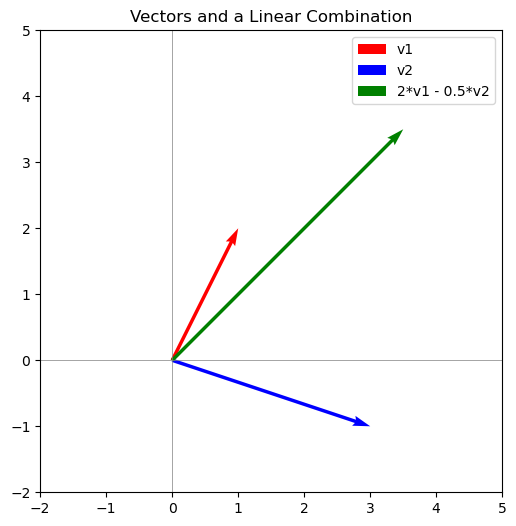

In [4]:

def plot_vector(v, label=None, color='black'):
    """Plot a single vector from the origin with a given color."""
    plt.quiver(
        0, 0, 
        v[0], v[1], 
        angles='xy', scale_units='xy', scale=1, 
        color=color, label=label
    )

combo = 2 * v1 + 0.5 * v2

plt.figure(figsize=(6,6))
plot_vector(v1, label='v1', color='red')
plot_vector(v2, label='v2', color='blue')
plot_vector(combo, label='2*v1 - 0.5*v2', color='green')

plt.axhline(0, color='gray', linewidth=0.5)
plt.axvline(0, color='gray', linewidth=0.5)

plt.xlim(-2, 5)
plt.ylim(-2, 5)
plt.gca().set_aspect('equal', 'box')
plt.legend()
plt.title("Vectors and a Linear Combination")
plt.show()




## 3. Real example (NLP): term–document matrix

We work with a tiny shared corpus stored in `data/sample_corpus.txt`:

```
this movie was amazing and inspiring
the movie was boring and slow
amazing acting but the story was boring
boring movie with terrible acting
```

We will:
1. Load the corpus
2. Tokenize
3. Build a vocabulary
4. Build a **term–document matrix** `X` where each **document vector** is in $\mathbb{R}^{|\text{vocab}|}$


In [5]:

# Load corpus
import pandas as pd
import numpy as np
import re

# Load CSV
corpus_path = r"D:\Projects\MatrixMatters\titanic_reviews_clean.csv"
df = pd.read_csv(corpus_path)

# Extract review text column
corpus = df["review_text"].astype(str).tolist()

# Tokenizer function (clean + split)
def tokenize(text):
    # keep only alphabetic characters, lowercase everything
    return re.findall(r"[a-z]+", text.lower())

# Tokenize corpus
tokenized = [tokenize(doc) for doc in corpus]

# Build vocabulary
vocab = sorted(set(w for doc in tokenized for w in doc))
word_to_idx = {w: i for i, w in enumerate(vocab)}

V = len(vocab)
X = np.zeros((len(corpus), V), dtype=int)

# Build term–document matrix
for i, doc in enumerate(tokenized):
    for w in doc:
        X[i, word_to_idx[w]] += 1

# Print summary
print("Documents (n):", len(corpus))
print("Vocabulary (V):", V)
print("\nSample vocab (first 30 words):", vocab[:30])
print("Term–document matrix shape:", X.shape)

# Show first document vector
print("\nDoc 1:", corpus[0])
print("Vector:", X[0])
print("Nonzero entries:", np.count_nonzero(X[0]))



Documents (n): 100
Vocabulary (V): 152

Sample vocab (first 30 words): ['a', 'acting', 'again', 'an', 'and', 'appreciated', 'at', 'balanced', 'be', 'beautifully', 'between', 'both', 'brilliance', 'brilliant', 'but', 'can', 'captures', 'characters', 'chemistry', 'cliches', 'combine', 'connect', 'craft', 'delivers', 'despite', 'detail', 'didn', 'direction', 'dragged', 'emotion']
Term–document matrix shape: (100, 152)

Doc 1: Titanic offers a balanced mix of emotion and grandeur. It's technically brilliant but emotionally inconsistent.
Vector: [1 0 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Nonzero entries: 16



### 3.1 Linear combinations & span in the NLP space

- A **document vector** is a point in high-dimensional space.  
- A **linear combination** of two document vectors is still a vector in the same space.
- The **span** of a set of document vectors is the set of all their linear combinations.


In [6]:

d1 = X[0].astype(float)
d2 = X[1].astype(float)

alpha, beta = 0.3, 0.7
combo = alpha * d1 + beta * d2

print("d1:", d1)
print("d2:", d2)
print(f"Linear combination {alpha}*d1 + {beta}*d2:", combo)


d1: [1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
d2: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0.]
Linear combination 0.3*d1 + 0.7*d2: [0.3 0.  0.  0.  1.  0.  0. 


## 4. Exercises (Try it yourself)

1. **Vector manipulation:** Create two new 2D vectors of your choice and plot them plus a linear combination.  
2. **Custom corpus:** Add one more document to `data/sample_corpus.txt`, rebuild the vocabulary and term–document matrix, and observe how shapes and vectors change.  
3. **Interpretation:** Pick any two words and compare their **word vectors** (columns of `X`). In what kinds of documents do they appear together?  
4. **Stretch goal:** Create a function `build_term_doc_matrix(corpus)` that returns `(X, vocab, word_to_idx)` and reuse it in later notebooks.
